# Lab 2: Supervised Learning

In this lab, we prepare our Kiva data for a linear regression, and run linear regressions that attempt to answer a question we may have as Kiva borrowers: *What drives the loan amount requested by KIVA borrowers? * 

In the language of Module 1, our outcome feature is **loan_amount**. 

Here's a look ahead at what we'll be doing in this notebook: 

1. Load data and packages 

2. Create explanatory variables of interest 

3. Check our assumptions 

4. Linear Regression

5. Model Validation


First, we will load the packages we need for this section, and our data. As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Notebook 1, we merged these data files and created new variables to form the data frame "df", which we will use now. **If you haven't already, please run through Notebook 1!**  

In [248]:
## Import packages

import pandas as pd
import numpy as np
from datetime import datetime
from ggplot import *
from bs4 import BeautifulSoup
import re as re
import types
import datetime as dt   
%matplotlib inline

# packages for checking assumptions
from scipy import stats as stats

# packages for linear regression and validation 
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [104]:
# the command below means that the output of multiple commands in a cell will be output at once.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [105]:
# the command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

In [187]:
# Read in data

data_path = '~/intro_course_data_science_for_good/data/'
df = pd.read_csv(data_path+'df_module_1.csv', low_memory=False)

## Creating Explanatory Features of Interest

   ### Demographics

Since we are interested in using the demographics of the Kiva borrowers as potential explanatory features, we will create, clean, and otherwise prepare these for linear regression. We are using a new method: str.contains. You may remember the method np.where from Notebook 1. 

In the cell below we use Numpy's  [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function  and Panda's [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html) to create the widowed", "kids", and "elderly" features. 

We are using Numpy's filter the data such that we are only creating a Boolean variable for those observations in which we find the strings of interest - in this case, any variation of the words widow, and any indication of children. Note that we try to be inclusive by testing for variations like "daughter" and "son."

In [188]:
## Whether or not the borrower is widowed
#  Note the str.contains function
df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=0) ==True, 1, 0)

## Whether or not the borrower has children 
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter", na=0) ==True,1,0)

## Whether or not the borrower is elderly
df['elderly'] = np.where(df['tags'].str.contains("#Elderly", na=0) ==True, 1, 0)

In [189]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,...,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,widowed,kids,elderly
0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",...,to purchase more tea leaves to sell to the tea...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Female,0,1,0
1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",...,to buy timber to make more furniture for his e...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Male,0,1,0


In [190]:
age_tag = pd.read_csv(data_path+'age.csv')

In [191]:
age_tag.head(2)

,age,age_int,Unnamed: 2
0,1 years,1,1
1,2 years,1,2


In [192]:
## Age of borrower

#loop that parses out all words, finds age match and creates new field

def text_search(tag):
    #creates empty lists that are then added to in loop
    age=[]
    flag = tag.astype(str)
    match=flag.tolist()
    match = re.compile(r'\b(?:%s)\b' % '|'.join(match))
    for descr in df['description.texts.en']:
        try:
            if isinstance(descr, str):
                    if re.findall(match, descr):
                        match_0=re.findall(match,  descr)
                        match_1=re.findall(match,  descr)[:1]
                        word_1=" ".join(match_1)
                        age.append(word_1)
                    else:
                        age.append('')
        except:
            print('error')
            
    return(age)

In [193]:
age= text_search(age_tag['age'])
df['age']=pd.DataFrame(age)

In [194]:
df['age'].head(2)

0    44 years
1    42 years
Name: age, dtype: object

In [195]:
df=df.merge(age_tag, how='left', left_on='age', right_on='age')

In [196]:
df.sample(2)

,Unnamed: 0,Unnamed: 0.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,...,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,widowed,kids,elderly,age,age_int,Unnamed: 2
107338,107338,107280,Electronics Sales,NaN,False,"[{'first_name': 'Joel', 'last_name': '', 'gend...",NaN,['en'],Joel is 26 years old and married. He sells el...,NaN,NaN,NaN,1025,2011-12-29,348077,898082,1,0,0,30,1025,Kenya,KE,country,1 38,point,NaN,Joel,142.0,[],NaN,2011-11-03,Retail,funded,[],100000.0,KES,2011-10-14T07:00:00Z,1025,[],...,NaN,NaN,1,54.8,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.024923,0.619151,NaN,0.0,NaN,2081410.0,1.0,0.0,5945.0,Faulu Kenya,41.0,NaN,NaN,0.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2009-07-19T04:30:05Z,closed,2892775.0,http://www.faulukenya.com/,2011-11-03 02:20:04,NaN,2011-12-29 01:44:10,2011-10-14 07:00:00,1,2011-10-14,2011,11,Male,0,0,0,36 years,36.0,36.0
73535,73535,73485,General Store,NaN,False,"[{'first_name': 'Goretty Atieno', 'last_name':...",0.34,['en'],I grew up in both Nairobi and in Nyanza. The l...,NaN,NaN,NaN,125,2013-11-22,1079084,2194596,1,0,0,4,125,Kenya,KE,country,1 38,point,NaN,Goretty Atieno,NaN,[],2014-01-05,2013-11-22,Retail,funded,[],10000.0,KES,2013-11-23T05:05:20Z,125,[],...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-22 07:14:52,2014-01-05 23:14:52,2013-11-22 14:20:31,2013-11-23 05:05:20,1,2013-11-23,2013,11,Female,0,0,0,,NaN,NaN


In [173]:
df['age_int'].fillna(df['age_int'].mean())

0         44.00000
1         42.00000
2         38.54273
3         38.54273
4         38.54273
5         38.54273
6         38.54273
7         38.54273
8         34.00000
9         38.54273
10        38.54273
11        38.54273
12        38.54273
13        38.54273
14        38.54273
15        38.54273
16        38.54273
17        38.54273
18        54.00000
19        40.00000
20        38.00000
21        38.54273
22        38.54273
23        38.54273
24        38.54273
25        38.54273
26        38.54273
27        38.54273
28        38.54273
29        38.54273
            ...   
127928    38.54273
127929    38.54273
127930    38.54273
127931    38.54273
127932    38.54273
127933    38.54273
127934    38.54273
127935    38.54273
127936    38.54273
127937    38.54273
127938    38.54273
127939    38.54273
127940    38.54273
127941    38.54273
127942    38.54273
127943    38.54273
127944    38.54273
127945    38.54273
127946    38.54273
127947    38.54273
127948    38.54273
127949    38

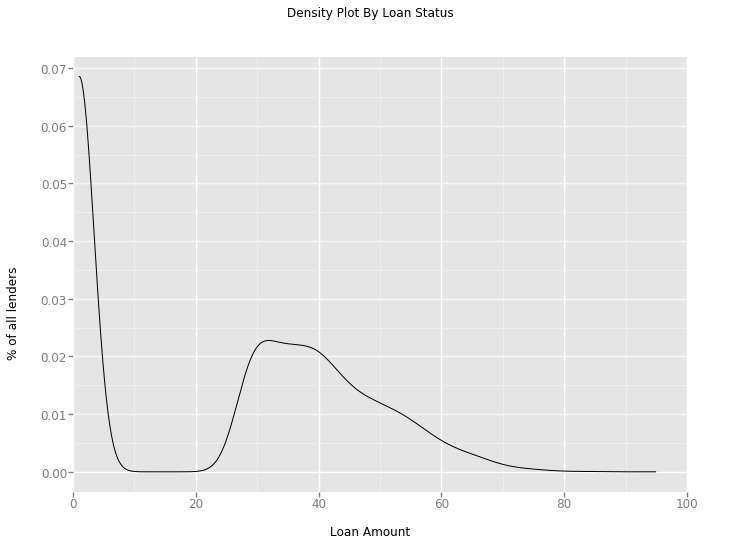

<ggplot: (300467790)>

In [197]:
p=ggplot(df, aes(x='age_int')) + geom_density() + xlim(0,100) + \
ggtitle("Density Plot By Loan Status") + xlab("Loan Amount") + ylab("% of all lenders")

p

### Loan features

Next we create features related to the conditions surrounding each loan posting, including: 

-Whether or not a borrower has included a video

-Whether or not a borrower has included a picture

Here, our intuition tells us that if a borrower includes more personal details and imagery, lenders are more likely to lend to them. We create this variable so we can differentiate between loans that have these personal details and loans that do not.   

In [198]:
## Features of the loan posting

## Does the borrower include a video? 
df['video'] = np.where(pd.isnull(df['video.id']) ==False, True, False)

## Does the borrower include a picture? 
df['pictured'] = np.where(pd.isnull(df['image.id']) ==False, True, False)

In order to get information on time, we first need to make sure that the data is in Python's datetime format. Once all relevant features are converted to this format, we can perform operations on them. In this case, we want to find out how many days elapsed between two dates, so we subtract the earlier date from the later date and report the output in days. 

As we saw in Module 1, we already ensured our date features are converted to datetime format using the `to_datetime` function. However, in reading in our "df" csv file, Python forgot the Pandas format we assigned. Therefore we convert our created variables to datetime format again. We then create a day feature from each of the datetime differences we calculate.

In [261]:
## Ensuring datetime format
df['planned_expiration_datetime'] = pd.to_datetime(df['planned_expiration_datetime'])
df['posted_datetime'] = pd.to_datetime(df['posted_datetime'])
df['partner_start_datetime']=pd.to_datetime(df['partner_start_date'])

## Time to expiration is the expiration date minus the Posted Date
df['time_to_expire_datetime'] =df['planned_expiration_datetime'] - df['posted_datetime']
df['days_to_expire'] = df.time_to_expire_datetime.dt.days
df['partner_start_date']=df['partner_start_datetime'].dt.date
df['partner_start_year']=df['partner_start_datetime'].dt.year
df['partner_time_w_kiva']=pd.to_datetime('today')-pd.to_datetime(df['partner_start_date'])

In [262]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,...,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,widowed,kids,elderly,age,age_int,Unnamed: 2,video,pictured,time_to_expire_datetime,days_to_expire,eco_friendly,animals,technology,log_loan_amount,partner_id_int,partner_start_datetime,partner_time_w_kiva,partner_start_year
0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",...,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Female,0,1,0,44 years,44.0,44.0,False,True,30 days,30.0,0,0,0,6.214608,386.0,2014-05-29,1096 days,2014.0
1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",...,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Male,0,1,0,42 years,42.0,42.0,False,True,30 days,30.0,0,0,0,6.214608,386.0,2014-05-29,1096 days,2014.0


In [251]:
print(dt.datetime.today())

2017-05-29 15:58:21.224815


### Tag Features

Next we create features related to miscellaneous relevant information included in the loan's tags. Specifically, it could be interesting to consider the following: 
1. Is the loan eco-friendly?
2. Does the loan relate to animals?  
3. Does the loan involve technology?

As with the demographic features above, we are using Numpy's [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function and Panda's [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html) to search for relevant tag-words

In [200]:
## Is the loan eco-friendly?
df['eco_friendly'] = np.where(df['tags'].str.contains("#Eco-friendly", na=0) ==True, 1, 0)

## Does the loan relate to animals?
df['animals'] = np.where(df['tags'].str.contains("#Animals", na=0) ==True, 1, 0)

## Does the loan involve technology?
df['technology'] = np.where(df['tags'].str.contains("#Technology", na=0) ==True, 1, 0)

## Checking Assumptions

### Normality
In Module 2, we reviewed that normal distribution of variables is an assumption underlying linear regression. Let's look first at our dependent variable, loan_amounts.

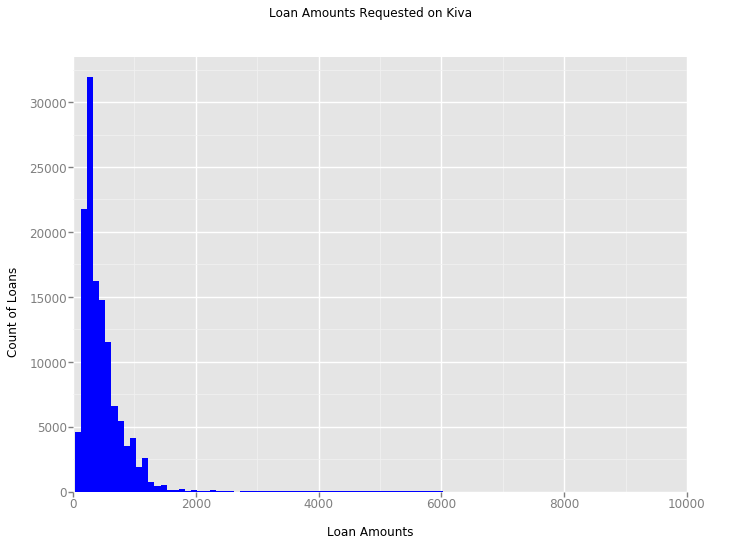

<ggplot: (308973751)>

In [201]:
ggplot(df, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 10000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

Let's remove outliers and see how the distribution changes.

In [209]:
# Calculate Outliers
df_removed_outliers=df[(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

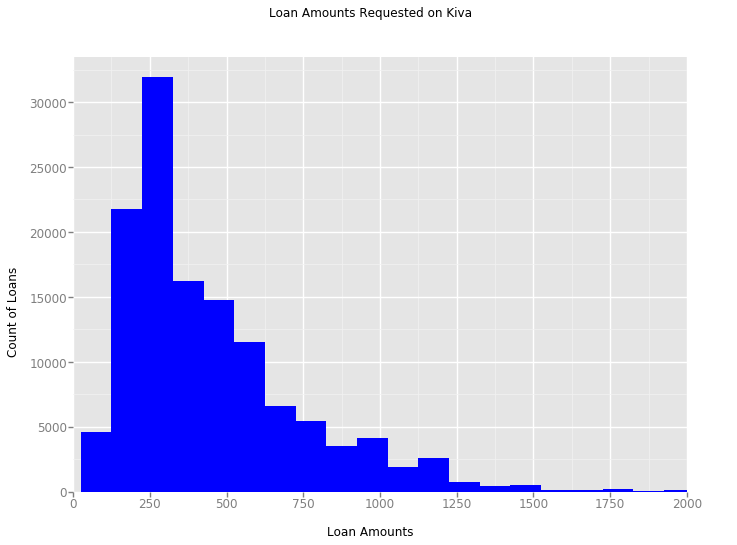

<ggplot: (347986054)>

In [212]:
ggplot(df_removed_outliers, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 2000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

In [213]:
df['loan_amount'].describe()

count    127958.000000
mean        472.279185
std         682.456070
min          25.000000
25%         250.000000
50%         350.000000
75%         600.000000
max       50000.000000
Name: loan_amount, dtype: float64

This data looks pretty skewed to the left, towards values of $25, which we know is the minimum Kiva asks from lenders. 

We can also do a more statistical test of skewness. [Scipy's stats package](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.skew.html) allows you to conduct a skew test. A normally distributed dataset would return about 0. A skewness value of greater than 0 means there is more in the left tail fo the distribution. Typically, a skew score of +-1 is deemed acceptable.

In [214]:
print(stats.skew(df.loan_amount, axis=None))

34.50497586801526


This confirms our suspicion that the data is skewed to the left. How can we fix this? 

One potential solution is to **log transform** your data. For a quick review of logarithms, look [here](https://www.mathsisfun.com/algebra/logarithms.html). 

Note that when we log transform data, we change our interpretation of the final regression output. Previously we had a simple linear equation... 

    y = mx + b

This could be interpreted as, with every unit increase in x, we get a m increase in outcome feature y. Now we have a log equation: 

    log(y) = mx + b
    
This is less intuitive, as we have to solve for y. When we solve for y through exponentiation, we get the following equation: 

    y = 10^(mx + b)
    y = 10^(mx) * 10^(b)

The default base for log is 10. The takeaway here is that the impact x would have on y is much larger than linear - it is **exponentiated**. We will return to this interpretation in the discussion of the linear regression model. Let's try log transforming our loan_amount variable. 

In [215]:
df['log_loan_amount'] = np.log(df['loan_amount'])

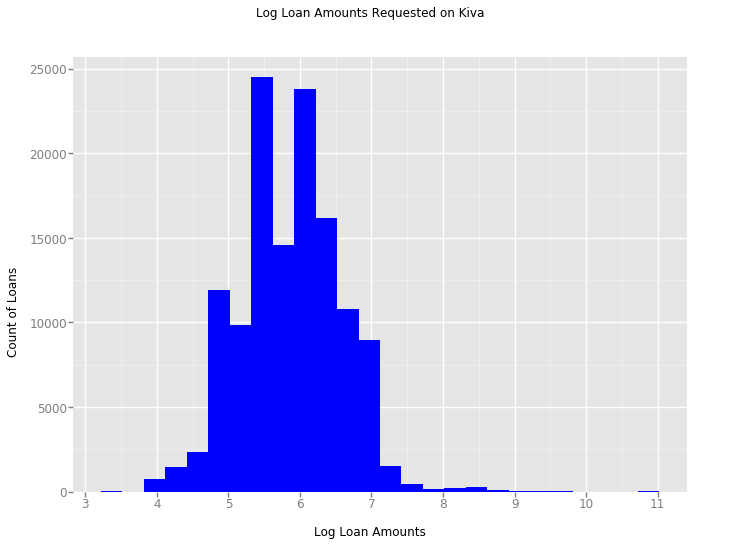

<ggplot: (352060827)>

In [216]:
ggplot(df, aes(x='log_loan_amount')) + geom_histogram(binwidth=0.3, fill="blue") + \
ggtitle("Log Loan Amounts Requested on Kiva") + xlab("Log Loan Amounts") + ylab("Count of Loans")

In [217]:
print(stats.skew(df['log_loan_amount']))

0.162080171976504


Great! This looks much closer to normal, both in the chart and in our skew statistic.

Let's turn now to checking our other assumptions.

### Check for multicollinearity

Numpy's Corrcoef function returns a matrix of Pearson correlation coefficients. To recap Module 2's lesson, multicollinearity is a problem when we have highly correlated explanatory features, as this makes it difficult for the model to try to differentitae between each feature's influence on the explanatory feature. Read more about Numpy's Corrcoef [here](https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.corrcoef.html).

Try running different features!

In [10]:
np.corrcoef(df.loan_amount, df.funded_amount)

array([[ 1.        ,  0.97333343],
       [ 0.97333343,  1.        ]])

This tells us that loan amount and funded amount are extremely highly correlated - a vast majority of loans requested get funded! Normally, we would be interested in both loan_amount and funded_amount as an outcome feature, but here we see that it would be redundant to test both. 

It would take a long time for us to test each and every relationship between two sets of variables, so let's create a correlation matrix that lets us visualize every correlation in a dataset using Pandas.

In [12]:
df_corr_tbl = df[['funded_amount', 'loan_amount', 'log_loan_amount', 'lender_count', 'borrower_count', 'gender', 'widowed', 'kids', 'video', 'pictured', 'days_to_expire']]
df_corr_tbl.corr()

,funded_amount,loan_amount,log_loan_amount,lender_count,borrower_count,widowed,kids,video,pictured,days_to_expire
funded_amount,1.000000,0.973333,0.569338,0.966091,0.199865,-0.016536,-0.036267,0.138491,NaN,0.082532
loan_amount,0.973333,1.000000,0.592568,0.936628,0.217043,-0.019917,-0.030220,0.132316,NaN,0.084827
log_loan_amount,0.569338,0.592568,1.000000,0.558347,0.359565,-0.033945,-0.040790,0.004814,NaN,0.076844
lender_count,0.966091,0.936628,0.558347,1.000000,0.182836,-0.014063,-0.031407,0.129759,NaN,0.081412
borrower_count,0.199865,0.217043,0.359565,0.182836,1.000000,-0.042936,0.065381,-0.005363,NaN,0.019546
widowed,-0.016536,-0.019917,-0.033945,-0.014063,-0.042936,1.000000,0.046876,0.009926,NaN,0.015540
kids,-0.036267,-0.030220,-0.040790,-0.031407,0.065381,0.046876,1.000000,-0.000634,NaN,-0.027457
video,0.138491,0.132316,0.004814,0.129759,-0.005363,0.009926,-0.000634,1.000000,NaN,0.016898
pictured,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
days_to_expire,0.082532,0.084827,0.076844,0.081412,0.019546,0.015540,-0.027457,0.016898,NaN,1.000000


Of course, not every correlation in this table will be meaningful. A correlation table is useful as it provides a visual shortcut to see what relationships might be problematic for multicollinearity. 

In [235]:
df['partner_id_int']=pd.to_numeric(df['partner_id'], errors='coerce')

## Linear Regression

Now we're relatively confident about what our data looks like, let's try some regressions. We will focus in on outcome feature loan_amount. We encourage you to explore other outcome features!  

As discussed in Module 2, we will divide the data into training and test sets so we can validate our regression results.

Note that training set should be larger than the test set, as we should train our model on as much data as possible. For this example, we divide the data 80% training / 20% test.

In [263]:
# Set training-test split %
split_pct = 0.80

# the pandas command "sample" already randomizes its selection. 
loans_full_shuffled = df.sample(frac=1)

train_set = loans_full_shuffled[:int((len(loans_full_shuffled)+1*split_pct))] 
test_set = loans_full_shuffled[int(len(loans_full_shuffled)*split_pct+1):]  

Now we have two separate datasets: train_set and test_set. We will run the regression on train_set
using statsmodel's "ols" function. Let's try a simple example to start: 

In [264]:
df.head(10)

,Unnamed: 0,Unnamed: 0.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,...,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,gender,widowed,kids,elderly,age,age_int,Unnamed: 2,video,pictured,time_to_expire_datetime,days_to_expire,eco_friendly,animals,technology,log_loan_amount,partner_id_int,partner_start_datetime,partner_time_w_kiva,partner_start_year
0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",...,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Female,0,1,0,44 years,44.0,44.0,False,True,30 days 00:00:00,30.0,0,0,0,6.214608,386.0,2014-05-29,1096 days,2014.0
1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",...,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,1,2017-04-03,2017,5,Male,0,1,0,42 years,42.0,42.0,False,True,30 days 00:00:00,30.0,0,0,0,6.214608,386.0,2014-05-29,1096 days,2014.0
2,2,2,Home Energy,0.0,False,"[{'first_name': 'Rose', 'last_name': '', 'gend...",NaN,['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,NaN,50,NaN,1291530,2515991,1,0,0,2,75,Kenya,KE,town,0.516667 35.283333,point,Eldoret,Rose,156.0,[],2017-06-08,2017-05-09,Personal Use,fundraising,"[{'name': '#Eco-friendly'}, {'name': '#Technol...",6000.0,KES,2017-04-28T07:00:00Z,75,"[{'due_date': '2017-05-14T07:00:00Z', 'amount'...",...,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.10,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15,active,7705925.0,http://www.juhudikilimo.com/,2017-05-09 00:30:04,2017-06-08 00:30:03,NaN,2017-04-28 07:00:00,1,2017-04-28,2017,5,Female,0,1,0,,NaN,NaN,False,True,29 days 23:59:59,29.0,1,0,1,4.317488,156.0,2010-01-15,2691 days,2010.0
3,3,3,Used Clothing,0.0,False,"[{'first_name': 'Jane', 'last_name': '', 'gend...",NaN,['en'],"Jane was born in the 1980, and she is happily ...",NaN,NaN,NaN,0,NaN,1291525,2515986,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Jane,386.0,[],2017-06-08,2017-05-09,Clothing,fundraising,[{'name': '#Eco-friendly'}],50000.0,KES,2017-04-03T07:00:00Z,5

In [238]:
df['partner_id_int'].dtype

dtype('float64')

In [265]:
model0 = sm.ols(formula="log_loan_amount ~ partner_start_year", data=train_set).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:        log_loan_amount   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1265.
Date:                Mon, 29 May 2017   Prob (F-statistic):          1.09e-275
Time:                        16:03:59   Log-Likelihood:            -1.2127e+05
No. Observations:              118316   AIC:                         2.425e+05
Df Residuals:                  118314   BIC:                         2.426e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -92.3093      2

In [243]:
model0 = sm.ols(formula="log_loan_amount ~ sector + gender + partner_id_int + partner_profitability", data=train_set).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:        log_loan_amount   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     1111.
Date:                Mon, 29 May 2017   Prob (F-statistic):               0.00
Time:                        15:44:04   Log-Likelihood:            -1.0025e+05
No. Observations:              106890   AIC:                         2.005e+05
Df Residuals:                  106872   BIC:                         2.007e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

This is the typical regression output. It's a lot to digest! Remember that our simple model can be represented as a linear equation, like this: 

    loan_amount = intercept + coef*male

Therefore, these results can be translated as follows: 

    loan_amount = 463.9520 + 93.3054*male

Noticeably, the coefficient for male is not small, suggesting that whether or not a borrower is male **does** influence loan_amount. We have a sufficient amount of confidence in this conclusion because the **p-value** is reported to be 0.000. In technical terms, the p-value is **the probability of getting results as extreme as the ones observed. **

In statistics, we want our results to fall within the 95% confidence interval, or the p-value to be <= 0.05. This means, "[i]f repeated samples were taken and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the population mean. A 95% confidence interval has a 0.95 probability of containing the population mean. 95% of the population distribution is contained in the confidence interval." [Read more here.](http://www.investopedia.com/terms/s/standard-error.asp) The p-value is an indicator of where we fall in the confidence interval. In English, small p-value (<= 0.05) indicates strong evidence that the coefficient is different than 0. 

This is a relatively simplified explanation of p-values. Don't worry if it's not immediately intuitive - [not even professional statisticians can easily explain this concept.](http://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) To get a deeper understanding, we recommend grabbing the nearest textbook on statistics to review! 

Note also that the Adjusted R Squared is extremely low. To recap lessons from Module 2, the Adjusted R Squared is an explanation of how much of the outcome feature can be explained by the model's explanatory features. This low Adj R Squared suggests that the predictive value of male is pretty low - it cannot be used as the single feature to predict loan_amount. 

This result is in line with our understanding of the world - there must be other factors influencing loan_amount. Let's try complicating the model by adding more explanatory features. 

#### Model 1

In [12]:
# we rename the terms.repayment_term for ease of reference
train_set = train_set.rename(columns={'terms.repayment_term': 'repayment_term'})
test_set = test_set.rename(columns={'terms.repayment_term': 'repayment_term'})

In [134]:
#df['eco_friendly'] = np.where(df['tags'].str.contains("#Eco-friendly", na=0) ==True, 1, 0)
#df['animals'] = np.where(df['tags'].str.contains("#Animals", na=0) ==True, 1, 0)
#df['technology'] = np.where(df['tags'].str.contains("#Technology", na=0) ==True, 1, 0)

model1 = sm.ols(formula="log_loan_amount ~ borrower_count + sector + kids + gender + widowed + pictured + video + posted_year +\
                days_to_expire + repayment_term + partner_profitability + eco_friendly + animals + elderly + technology", data=train_set)
model1_results = model1.fit()
print(model1_results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_loan_amount   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     1836.
Date:                Sun, 28 May 2017   Prob (F-statistic):               0.00
Time:                        15:06:29   Log-Likelihood:                -73913.
No. Observations:               89811   AIC:                         1.479e+05
Df Residuals:                   89783   BIC:                         1.481e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

This **multi-feature** (or multivariate) model is more aligned with our understanding of the world. We see that adding a picture to your profile increases the amount that you might ask for. We also see that males tend to get larger loans, and widows and those with children tend to get slightly smaller loans. Most coefficients have very low p-values - a good sign! 

Our Adjusted R Squared is higher than it was in the single-feature model. Let's get into how we evaluate the model in terms of predictiveness. 

## Model Validation

<i>How can we evaluate how our model is doing? </i>

In the previous section, we were able to get general ideas of how well our model was doing by using metrics like Adjusted R Squared, coefficients, and p-value. However, the goal of most machine learning is a model that can <b>predict outcome features accurately</b>. Recall that we randomly split our dataset into a training set (80%) and a test set (20%). Now we will use the results from the regression conducted on our training set to predict the outcome features for each observation in our test set. The difference between the predicted outcome feature and the actual outcome feature for each observation gives us an idea of how close we are to the mark.  

In the previous section, we used the **statsmodel** package in order to output a regression output table. Now, we run the regression using the **scikit-learn** package, which is optimized specifically for machine learning and allows us to validate our models easily. Remember this package - we will be returning to it for the rest of the class!  

#### Validation of Model 1:

In order to use scikit-learn to run a regression, we format the data differently than how we do when we use statsmodels. 

In scikit-learn, we want to make sure: 
1. Categorical features are converted Booleans with values of either 1 or 0
2. Data is separated into two separate and clean datasets: x and y, or explanatory features and outcome feature. 

We do this below in the pre-processing section.

In [13]:
# Separate out the outcome feature into training/testing sets 
#  using our already-made training and test datasets
train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)
train_set_y = train_set['log_loan_amount']
test_set_y = test_set['log_loan_amount']

In [14]:
## Process categorical variables

# Process categorical variable "Gender" into individual Boolean features. 
#  Since there are only two possible values, we can keep this short. 
train_set['gender_dummy'] = train_set['gender']=="Male"
test_set['gender_dummy'] = test_set['gender']=="Male"

# Process categorical variable "Sector" into individual Boolean features 
#  Since there are 15 different sectors, this requires more processing.

# Encode categorical variable 'sector' into numeric 
le = preprocessing.LabelEncoder()
le.fit(train_set['sector'])

# create array of sectors as numbers 
sector_as_num = le.transform(train_set['sector']).reshape(-1,1)

# One-hot encode sectors of loans so that each sector has its own Boolean column (statsmodel does this automatically)
enc = OneHotEncoder()
enc.fit(sector_as_num)
# Create array of columns
sector_dummies = enc.transform(sector_as_num).toarray()
sector_dummies = pd.DataFrame(sector_dummies, columns = ["dummy_"+str(i) for i in range(1,16)])
# Join array of boolean columns with original training set 
train_set = pd.concat([train_set, sector_dummies], axis=1)
test_set = pd.concat([test_set, sector_dummies], axis=1)

In [15]:
## Join the newly created Boolean features to the 
#   train and test sets of explanatory features

train_set_x = train_set[['borrower_count', 'kids', 'gender_dummy', 'widowed', 'pictured', 'video', \
                         'days_to_expire', 'repayment_term',
                         'dummy_1', 'dummy_2', 'dummy_3', 'dummy_4', 'dummy_5', 'dummy_6',\
                         'dummy_7','dummy_8','dummy_9','dummy_10','dummy_11','dummy_12','dummy_13',\
                         'dummy_14','dummy_15']]
test_set_x = test_set[['borrower_count', 'kids', 'gender_dummy', 'widowed', 'pictured', 'video', \
                        'days_to_expire', 'repayment_term',
                      'dummy_1', 'dummy_2', 'dummy_3', 'dummy_4', 'dummy_5', 'dummy_6', \
                       'dummy_7','dummy_8','dummy_9','dummy_10','dummy_11','dummy_12','dummy_13',\
                       'dummy_14','dummy_15']]

In [19]:
# In this section we impute missing values in the training and test sets. 

from sklearn.preprocessing import Imputer

# Create our imputer to replace missing values with the mean e.g.
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(train_set_x)

train_set_x_imp = imp.transform(train_set_x)
test_set_x_imp = imp.transform(test_set_x)

In [20]:
# Linear Regression

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
model1 = regr.fit(train_set_x_imp, train_set_y)
print(model1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


Now we print the coefficients to ensure that the outputs are the same as the ones we've gotten when we ran statsmodel. 

In [22]:
# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [  4.75126438e-04   2.16772311e-03  -3.74459387e-04   7.96831806e-03
   1.24900090e-16   7.45923218e-02  -2.82401817e-04  -1.48996694e-04
   1.33363184e-01  -1.41255571e-01  -4.54263650e-02  -4.69575242e-02
   9.88776873e-02   7.18419841e-02  -1.71259716e-01   7.56973484e-01
   1.10751783e-01   8.12488376e-02  -1.11377625e+00   1.71299860e-03
  -2.44343909e-02   1.03739659e-01   1.84600201e-01]


With scikit-learn, we're able to generate some exciting new metrics using our test_set that we created earlier on in the code. First, let's take a look at the predicted value of y, and the true y.  

In [26]:
#predicted y: 
predicted_y = regr.predict(test_set_x_imp)
#true y:
train_set_y

#Let's calculate the difference! 
y_diff = abs(predicted_y - train_set_y)
y_diff[1:10]

array([ 0.62038259,  0.7212248 ,  0.7828526 ,  0.77722218,  0.26508832,
        0.57169306,  0.68667778,  0.60415162,  0.07276459])

This is interesting, but the absolute value of the difference between predicted and true Y doesn't tell us too much on its own. However, it is used as an input in calculating many statistical measures of fit. Let's take a look: 

[Mean Absolute Error](https://www.kaggle.com/wiki/MeanAbsoluteError)

The mean absolute error is calculated as the mean of the distance between predicted and true Y. We take the absolute value of (predicted Y - true Y) so we capture the concept of distance for each observation. Then we take the mean over all observations to get a sense of the entire model. The closer the final statistic is to 0, the better.

In [28]:
print("Mean absolute error: %.2f"
     % np.mean(y_diff))

Mean absolute error: 0.52


[Root Mean Squared Error](https://www.kaggle.com/wiki/RootMeanSquaredError)

The root mean squared error is calculated as the square root of the mean of the difference between predicted and true Y squared. This is a little more complicated to interpret than the MAE, but a useful indication of fit. Like the MAE, the closer this final statistic is to 0, the better.  

We use both RMSE and MAE in practice. See [this blog post](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d) for a discussion of the difference between the two metrics.

In [30]:
print("Root mean squared error: %.2f"
      % np.sqrt(np.mean((predicted_y - train_set_y) ** 2)))

Root mean squared error: 0.64


## Next Steps

This method, called the "holdout method"  is only one way of many to validate a model that you create. In Module 3, we will introduce you to a new algorithm (decision trees) as well as multiple methods of validating your results. 